In [29]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# Load Data

customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [31]:
# Merge customer and transaction data

customer_transactions = pd.merge(transactions, customers, on='CustomerID', how='left')
customer_products = pd.merge(customer_transactions, products, on='ProductID', how='left')

customer_profiles = customer_products.groupby('CustomerID').agg({
    'ProductName': lambda x: ' '.join(x),  # Combine product names
    'Category': lambda x: ' '.join(x)     # Combine categories
}).reset_index()


In [5]:
# Concatenate product names and categories for a complete profile
# Vectorize the combined profiles using TF-IDF
# Compute cosine similarity between customers

customer_profiles['CombinedProfile'] = customer_profiles['ProductName'] + ' ' + customer_profiles['Category']
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(customer_profiles['CombinedProfile'])

similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [8]:
# Function to get top 3 similar customers for each customer

def get_top_3_similar(customer_index, similarity_matrix, customer_ids):
    similarities = similarity_matrix[customer_index]
    similar_indices = similarities.argsort()[-4:-1][::-1] 
    return [(customer_ids[i], similarities[i]) for i in similar_indices]

In [14]:
# Generate recommendations for the first 20 customers

customer_ids = customer_profiles['CustomerID'].tolist()
lookalike_results = {}

for i, customer_id in enumerate(customer_ids[:20]):
    lookalike_results[customer_id] = get_top_3_similar(i, similarity_matrix, customer_ids)

In [15]:
# Convert results into a DF and save as CSV

lookalike_df = pd.DataFrame([{'CustomerID': k, 'Lookalikes': v} for k, v in lookalike_results.items()])
lookalike_df['Lookalikes'] = lookalike_df['Lookalikes'].apply(lambda x: [(cid, round(score, 2)) for cid, score in x])

In [18]:
# Save Output

lookalike_df.to_csv('Harshil_Ameta_Lookalike.csv', index=False)

In [17]:

print(lookalike_df.head())


  CustomerID                                     Lookalikes
0      C0001  [(C0197, 0.85), (C0026, 0.76), (C0045, 0.75)]
1      C0002  [(C0133, 0.92), (C0173, 0.77), (C0164, 0.73)]
2      C0003  [(C0164, 0.79), (C0181, 0.72), (C0085, 0.69)]
3      C0004  [(C0075, 0.77), (C0008, 0.77), (C0118, 0.77)]
4      C0005    [(C0096, 0.8), (C0128, 0.71), (C0014, 0.7)]


In [19]:
# Analyze similarity score distribution
all_similarity_scores = [
    score for recommendations in lookalike_results.values() for _, score in recommendations
]

In [22]:
# Calculate and display basic statistics for similarity scores
score_stats = {
    'mean': np.mean(all_similarity_scores),
    'median': np.median(all_similarity_scores),
    'min': np.min(all_similarity_scores),
    'max': np.max(all_similarity_scores),
    'std': np.std(all_similarity_scores)
}
print("Similarity Score Statistics:", score_stats)


Similarity Score Statistics: {'mean': 0.7583015777721123, 'median': 0.7600693780929353, 'min': 0.6504907330370865, 'max': 0.9675058557057117, 'std': 0.060081823550248305}


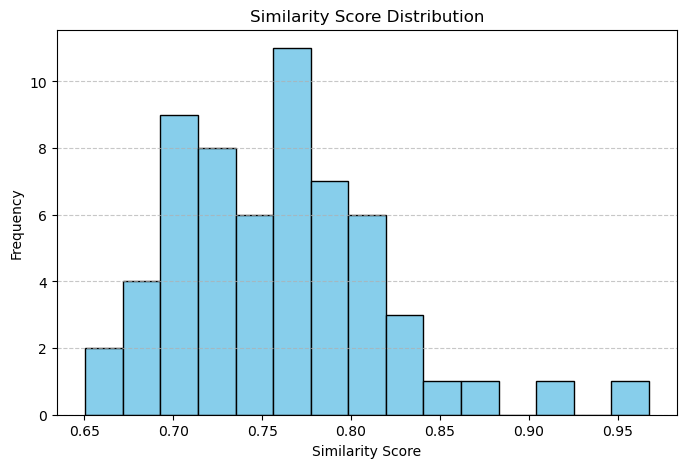

In [23]:
# Plot similarity score distribution
plt.figure(figsize=(8, 5))
plt.hist(all_similarity_scores, bins=15, color='skyblue', edgecolor='black')
plt.title('Similarity Score Distribution')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [24]:
# Qualitative analysis of recommendations
# Function to extract a customer's profile for qualitative analysis
# Randomly select a customer for qualitative analysis

def get_customer_profile(customer_id, customer_profiles, customer_products):
    profile = customer_profiles[customer_profiles['CustomerID'] == customer_id]
    transactions = customer_products[customer_products['CustomerID'] == customer_id][['ProductName', 'Category']]
    return profile, transactions

random_customer_id = np.random.choice(list(lookalike_results.keys()))
random_customer_recommendations = lookalike_results[random_customer_id]

In [26]:
# Retrieve the original customer's profile and their recommendations
original_profile, original_transactions = get_customer_profile(random_customer_id, customer_profiles, customer_products)
recommendation_profiles = []
recommendation_transactions = []
for rec_id, score in random_customer_recommendations:
    profile, transactions = get_customer_profile(rec_id, customer_profiles, customer_products)
    recommendation_profiles.append((rec_id, score, profile))
    recommendation_transactions.append((rec_id, transactions))

In [28]:
# Display qualitative analysis results
print("\nQualitative Analysis for Customer:", random_customer_id)
print("Original Customer Transactions:")
print(original_transactions.head())
for rec_id, score, profile in recommendation_profiles:
    print(f"\nRecommendation - Customer {rec_id} (Similarity Score: {round(score, 2)}):")
    print(recommendation_transactions[[r[0] for r in recommendation_transactions].index(rec_id)][1].head())


Qualitative Analysis for Customer: C0012
Original Customer Transactions:
                  ProductName     Category
76    ActiveWear Cookware Set   Home Decor
80    ActiveWear Cookware Set   Home Decor
120  ComfortLiving Smartphone  Electronics
210       HomeSense Desk Lamp   Home Decor
247   ComfortLiving Biography        Books

Recommendation - Customer C0136 (Similarity Score: 0.87):
                    ProductName    Category
89          BookWorld Biography       Books
251     ComfortLiving Desk Lamp  Home Decor
271  ComfortLiving Cookware Set  Home Decor
362         ActiveWear Cookbook       Books
446               SoundWave Rug  Home Decor

Recommendation - Customer C0076 (Similarity Score: 0.81):
                 ProductName    Category
64               TechPro Rug  Home Decor
75   ActiveWear Cookware Set  Home Decor
260  ComfortLiving Desk Lamp  Home Decor
334      ActiveWear Textbook       Books
820    ComfortLiving Sweater    Clothing

Recommendation - Customer C0059 (Simila